# Fourier basis

In [1]:
import autograd.numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from ml_uncertainty.model_inference import ParametricModelInference
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import pandas as pd

from skfda.representation.basis import FourierBasis
from sklearn.preprocessing import FunctionTransformer

In [2]:
# Let's consider some data that can be represented with a Fourier basis. 
# Here, we use the BasicMotions dataset from UCR.
# Source: https://www.timeseriesclassification.com/description.php?Dataset=BasicMotions

from skfda.datasets import fetch_ucr

Dataset description: 
 ---------

The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. 
The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and
badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, 
for a ten second period.


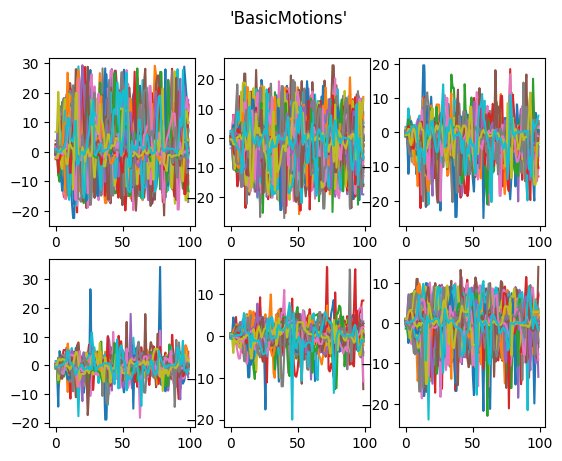

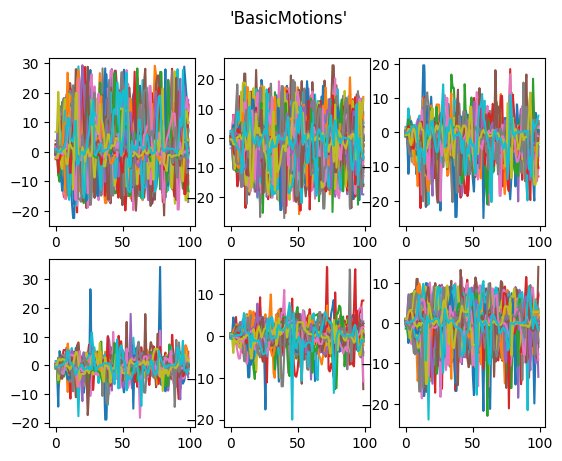

In [3]:
dataset = fetch_ucr("BasicMotions")

print("Dataset description: \n ---------\n")
print(dataset["DESCR"])
dataset["data"].plot()

In [4]:
# For illustration purposes, let's focus on the accelerometer data in the x dimension. I.e., we are focusing on the first dimension.
# Let us also focus on the data generated by the 1st student at the first try.
y_true = dataset["data"].data_matrix[1, :, 5]

# The data here shows a large amplitude in the beginning. To get an easier dataset for us to deal with, we remove that.
y_true = y_true[20:]

# Even though the timestamps aren't explcitily provided, we are told that data are collected every 1/10th second for 10 seconds.
# Reshape to match with SKLearn conventions. 
X_true = np.linspace(2, 10, 80).reshape(-1, 1)

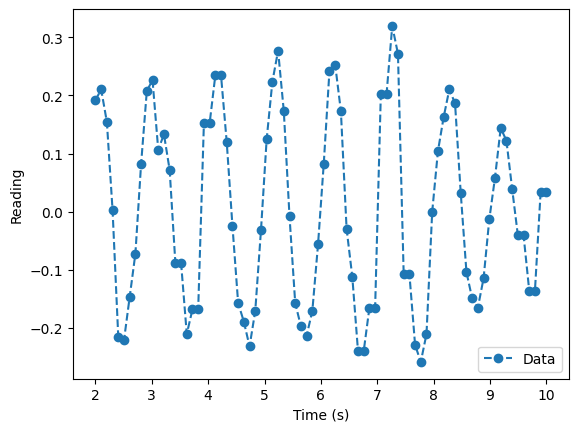

In [5]:
# Let's plot the data to visualize it.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Reading")
ax.plot(X_true[:, 0], y_true , marker="o", ls="--", label="Data")
ax.legend(loc="lower right")

In [6]:
# The goal is for us to fit a Fourier basis function and then quantify the uncertainty in the outputs.
# This will be useful if we train a ML model to predict this data.

# First, we create a Fourier basis.
fourier_expansion = FourierBasis(domain_range=(0, 10), n_basis=3, period=1)

# Check the shape of the expanded variable.
# print(fourier_expansion(X_true).shape)

# The following transformation does 2 things to align with the sklearn conventions.
# 1. Note that the output shape of the Fourier basis function in this is n_basis x n_time x 1. For sklearn,
# we need the input to be of the shape n_time x n_basis. Thus, we need to transform the output to match that
# shape. For this, we will use the FunctionTransformer class in sklearn preprocessing.
# 2. Note that the first term is the intercept and we wish to treat it accordingly during regression and 
# error estimation. Thus, we remove it from the data and rely on the fit_intercept=True method in LinearRegression to achieve this. 
func_trans = FunctionTransformer(lambda X: X.T[0, ..., 1:])

# Use linear regression model to fit the data to the basis expansiona and obtain coefficients.
linear_model = LinearRegression()

# NOTE: Ideally, we would have used a pipeline method to operate on X as it is the cleanest method.
# However, the pipeline methods are not available in the Fourier basis case since it comes from a different package.
# This, we manually pass through the X.
def preprocess_X(X_true):
    X_trans = fourier_expansion(X_true)
    X_trans = func_trans.transform(X_trans)
    return X_trans
    
# Now, we can fit the linear model to this. 
linear_model.fit(preprocess_X(X_true), y_true)

# Now, we can predict the y values.
y_pred = linear_model.predict(preprocess_X(X_true))

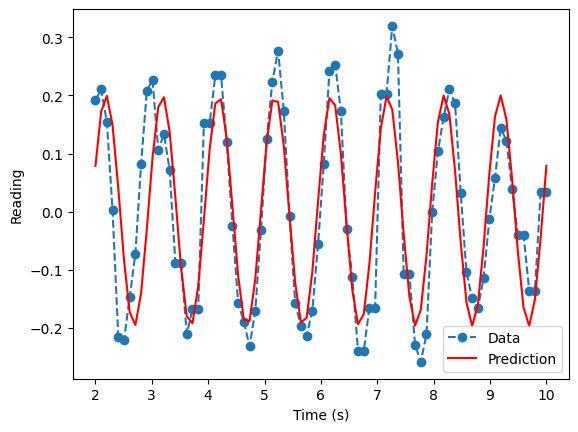

In [7]:
# Plot the true and predicted Fourier data.
ax.plot(X_true[:, 0], y_pred, linestyle="-", color="red", label="Prediction")
ax.legend(loc="lower right")
fig

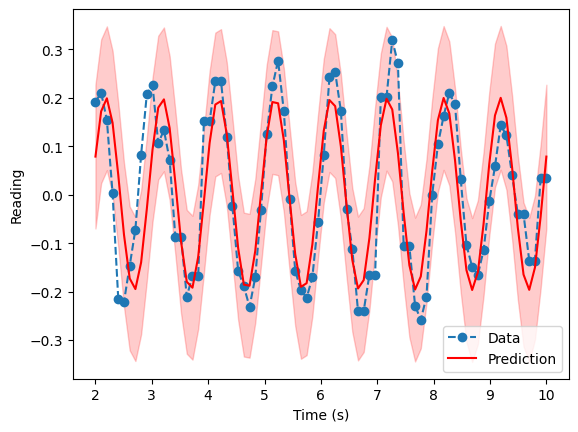

In [8]:
# Now, we can predict the uncertainty in parameters and prediction intervals using the standard ML uncertainty workflow.
inf = ParametricModelInference()
inf.set_up_model_inference(X_train=preprocess_X(X_true), 
                               y_train=y_true, estimator=linear_model)

# Get prediction intervals on the features.
df_feature_imp = inf.get_parameter_errors()

# Getting prediction intervals for X_expt values.
df_int = inf.get_intervals(preprocess_X(X_true))

# Add error bars from the package.
ax.fill_between(
    X_true[:, 0],
    df_int["lower_bound"],
    df_int["upper_bound"],
    color="red",
    alpha=0.2,
    zorder=0,
)
ax.legend(loc="lower right")
fig


*Note:* This is only an illustrative example to show how one express data with a Fourier basis and exploit ML uncertainty to 
characterize the uncertainties. In real life, for wave-like signals, one might prefer to use Fourier transforms and get related but different results.

Reference: https://stats.stackexchange.com/questions/249198/from-a-statistical-perspective-fourier-transform-vs-regression-with-fourier-bas